In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,550 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upload your file image107.jpg
Recognized text: 925594328


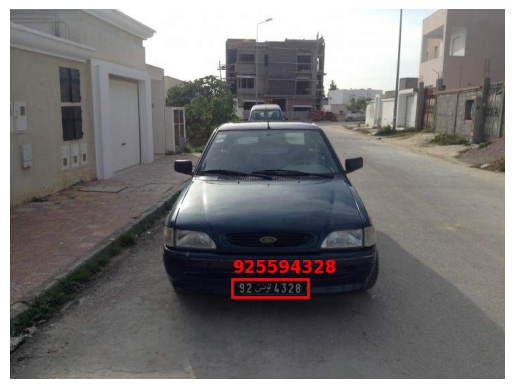

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Paths to your data
annotation_csv_path_detection = '/content/drive/MyDrive/Licplatesdetection_train.csv'
annotation_csv_path_recognition = '/content/drive/MyDrive/Licplatesrecognition_train.csv'
image_folder_path = '/content/drive/MyDrive/unzipped_file_carimages/license_plates_detection_train'

import pandas as pd
import cv2
import pytesseract
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

# Load annotations
df_detection = pd.read_csv(annotation_csv_path_detection)

# Define a function to convert annotations to YOLO format
def convert_to_yolo(row):
    x_min = row['xmin']
    x_max = row['xmax']
    y_min = row['ymin']
    y_max = row['ymax']

    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + (width / 2)
    y_center = y_min + (height / 2)

    return f"0 {x_center} {y_center} {width} {height}"

# Apply conversion
df_detection['yolo_annotation'] = df_detection.apply(convert_to_yolo, axis=1)

# Save the converted annotations
df_detection.to_csv('/content/drive/MyDrive/Licplatesdetection_train_yolo.csv', index=False)

# Function to perform OCR on a cropped license plate image and extract alphanumeric characters
def ocr_license_plate(cropped_plate_image):
    # Perform OCR using pytesseract
    text = pytesseract.image_to_string(cropped_plate_image, config='--psm 8 --oem 3')
    # Extract only alphanumeric characters using regular expressions
    alphanumeric_text = re.sub(r'[^a-zA-Z0-9]', '', text)
    return alphanumeric_text

# Function to plot image with bounding box and OCR text
def plot_image_with_bbox(image_path, bbox, plate_text):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add OCR text
    plt.text(xmin, ymin - 10, plate_text, color='red', fontsize=12, weight='bold')

    plt.axis('off')  # Turn off axis labels
    plt.show()

# Function to get bounding box coordinates from the annotation DataFrame
def get_bbox_from_annotations(image_name):
    row = df_detection[df_detection['img_id'] == image_name].iloc[0]
    return row['xmin'], row['ymin'], row['xmax'], row['ymax']

# Example usage
image_name = str(input("Upload your file image") ) # Replace with your actual image file name
image_path = f'{image_folder_path}/{image_name}'

# Get bounding box coordinates from annotations
xmin, ymin, xmax, ymax = get_bbox_from_annotations(image_name)

bbox = (xmin, ymin, xmax, ymax)

# Crop the plate image using the bounding box
image = cv2.imread(image_path)
cropped_plate_image = image[ymin:ymax, xmin:xmax]

if cropped_plate_image is None:
    print(f"Failed to load image from path: {image_path}")
else:
    plate_text = ocr_license_plate(cropped_plate_image)
    print("Recognized text:", plate_text)

    # Plot image with bounding box and OCR text
    plot_image_with_bbox(image_path, bbox, plate_text)
